In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np

import time

import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display


## 1. SPINN

In [3]:
class SPINN(nn.Module):
    def __init__(self, features, k=1.0):
        super().__init__()
        self.features = features
        self.k = k  # волновое число
        
        # Создаем слои для трех пространственных координат (x, y, z)
        self.networks = nn.ModuleList([
            self._build_network() for _ in range(3)
        ])
        
        # Слои для объединения выходов
        self.combine_layer1 = nn.Linear(features[-1] * 2, features[-1])
        self.combine_layer2 = nn.Linear(features[-1] * 2, features[-1])
        self.final_layer = nn.Linear(features[-1], 1)
        self.activation = nn.SiLU()
    
    def _build_network(self):
        layers = []
        layers.append(nn.Linear(1, self.features[0]))
        layers.append(nn.SiLU())
        
        for i in range(len(self.features) - 2):
            layers.append(nn.Linear(self.features[i], self.features[i + 1]))
            layers.append(nn.SiLU())
            
        layers.append(nn.Linear(self.features[-2], self.features[-1]))
        layers.append(nn.SiLU())
        return nn.Sequential(*layers)
    
    def _ensure_2d(self, x):
        if x.dim() == 1:
            return x.unsqueeze(1)
        return x
    
    def forward(self, x, y, z):
        # Преобразуем входы в 2D тензоры [batch_size, 1]
        x = self._ensure_2d(x)
        y = self._ensure_2d(y)
        z = self._ensure_2d(z)
        
        # Пропускаем через отдельные сети
        x_features = self.networks[0](x)
        y_features = self.networks[1](y)
        z_features = self.networks[2](z)
        
        # Объединяем признаки
        combined = torch.cat([x_features, y_features], dim=1)
        combined = self.activation(self.combine_layer1(combined))
        
        combined = torch.cat([combined, z_features], dim=1)
        combined = self.activation(self.combine_layer2(combined))
        
        # Финальный слой
        output = self.final_layer(combined)
        return output.squeeze(-1)
    
# Функция для вычисления производных второго порядка
def compute_second_derivative(u, x):
    du_dx = torch.autograd.grad(
        u.sum(), x, 
        create_graph=True,
        retain_graph=True
    )[0]
    d2u_dx2 = torch.autograd.grad(
        du_dx.sum(), x,
        create_graph=True,
        retain_graph=True
    )[0]
    return d2u_dx2

class SPINN_Loss:
    def __init__(self, model, k=None):
        self.model = model
        self.k = k if k is not None else model.k

    def residual_loss(self, x, y, z, source_term):
        x.requires_grad_(True)
        y.requires_grad_(True)
        z.requires_grad_(True)
        
        u = self.model(x, y, z)
        
        uxx = compute_second_derivative(u, x)
        uyy = compute_second_derivative(u, y)
        uzz = compute_second_derivative(u, z)
        
        # Уравнение Гельмгольца в 3D: ∇²u + k²u = f
        # или: uxx + uyy + uzz + k²u = f
        residual = uxx + uyy + uzz + self.k**2 * u - source_term
        return torch.mean(residual**2)

    def boundary_loss(self, x, y, z, u_true=None):
        """
        Вычисляет ошибку на границе.
        x, y, z - списки тензоров для разных сегментов границы
        u_true - список тензоров или None для нулевых граничных условий
        """
        loss = 0.0
        
        # Проходим по всем сегментам границы
        for i in range(len(x)):
            u_pred = self.model(x[i], y[i], z[i])
            
            if u_true is None:
                # Нулевые граничные условия
                loss += torch.mean(u_pred**2)
            else:
                # Заданные граничные условия
                loss += torch.mean((u_pred - u_true[i])**2)
        
        # Возвращаем среднее значение ошибки по всем сегментам
        return loss / len(x)

    def __call__(self, *train_data):
        xc, yc, zc, fc, xb, yb, zb, ub = train_data
        
        loss_residual = self.residual_loss(xc, yc, zc, fc)
        loss_boundary = self.boundary_loss(xb, yb, zb, ub)
        
        return loss_residual + loss_boundary


# Функция шага оптимизации
def update_model(model, optimizer, train_data):
    optimizer.zero_grad()
    loss = SPINN_Loss(model)(*train_data)
    loss.backward()
    optimizer.step()
    return loss.item()

## 2. Data generator

In [4]:
def helmholtz3d_exact_u(a1, a2, a3, x, y, z):
    return torch.sin(a1*torch.pi*x) * torch.sin(a2*torch.pi*y) * torch.sin(a3*torch.pi*z)

def helmholtz3d_source_term(a1, a2, a3, x, y, z, lda=1.):
    u_gt = helmholtz3d_exact_u(a1, a2, a3, x, y, z)
    
    # Вычисление вторых производных
    uxx = -(a1*torch.pi)**2 * u_gt
    uyy = -(a2*torch.pi)**2 * u_gt
    uzz = -(a3*torch.pi)**2 * u_gt
    
    # Возвращаем источниковый член уравнения Гельмгольца
    return uxx + uyy + uzz + lda*u_gt

def spinn_train_generator_helmholtz3d(NC, NB, seed=42, domain_size=1.0, k=1.0):
    torch.manual_seed(seed)
    
    # Точки внутри области (коллокационные точки)
    xc = torch.rand(NC) * 2 * domain_size - domain_size
    yc = torch.rand(NC) * 2 * domain_size - domain_size
    zc = torch.rand(NC) * 2 * domain_size - domain_size
    
    # Источниковая функция для правой части уравнения Гельмгольца
    # Пример: источниковый член для известного решения u = sin(πx)sin(πy)sin(πz)
    pi = torch.tensor(np.pi)
    fc = (3 * pi**2 + k**2) * torch.sin(pi * xc) * torch.sin(pi * yc) * torch.sin(pi * zc)
    
    # Генерация граничных точек
    xb = []
    yb = []
    zb = []
    ub = []
    
    # Точки на границах x = -domain_size и x = domain_size
    x_boundary = torch.full((NB,), -domain_size)
    xb.append(x_boundary)
    yb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    zb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    ub.append(torch.zeros(NB))  # Нулевые граничные условия
    
    x_boundary = torch.full((NB,), domain_size)
    xb.append(x_boundary)
    yb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    zb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    ub.append(torch.zeros(NB))  # Нулевые граничные условия
    
    # Точки на границах y = -domain_size и y = domain_size
    y_boundary = torch.full((NB,), -domain_size)
    xb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    yb.append(y_boundary)
    zb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    ub.append(torch.zeros(NB))  # Нулевые граничные условия
    
    y_boundary = torch.full((NB,), domain_size)
    xb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    yb.append(y_boundary)
    zb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    ub.append(torch.zeros(NB))  # Нулевые граничные условия
    
    # Точки на границах z = -domain_size и z = domain_size
    z_boundary = torch.full((NB,), -domain_size)
    xb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    yb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    zb.append(z_boundary)
    ub.append(torch.zeros(NB))  # Нулевые граничные условия
    
    z_boundary = torch.full((NB,), domain_size)
    xb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    yb.append(torch.rand(NB) * 2 * domain_size - domain_size)
    zb.append(z_boundary)
    ub.append(torch.zeros(NB))  # Нулевые граничные условия
    
    return xc, yc, zc, fc, xb, yb, zb, ub

# Функция для генерации тестовых данных
def spinn_test_generator_helmholtz3d(NC_TEST, domain_size=1.0, k=1.0):
    # Создаем сетку точек
    x = torch.linspace(-domain_size, domain_size, NC_TEST)
    y = torch.linspace(-domain_size, domain_size, NC_TEST)
    z = torch.linspace(-domain_size, domain_size, NC_TEST)
    
    xm, ym, zm = torch.meshgrid(x, y, z)
    
    # Аналитическое решение для тестирования
    pi = torch.tensor(np.pi)
    u_gt = torch.sin(pi * xm) * torch.sin(pi * ym) * torch.sin(pi * zm)
    
    return xm.flatten(), ym.flatten(), zm.flatten(), u_gt.flatten(), xm, ym, zm


## 3. Utils

In [5]:
def relative_l2(u, u_gt):
    return torch.norm(u - u_gt) / torch.norm(u_gt)

def plot_helmholtz3d(x, y, z, u):
    x = x.detach().cpu().numpy().flatten()
    y = y.detach().cpu().numpy().flatten()
    z = z.detach().cpu().numpy().flatten()
    u = u.detach().cpu().numpy().flatten()
    
    u_norm = (u - u.min()) / (u.max() - u.min())
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=u_norm, s=1, cmap='seismic', vmin=0, vmax=1)
    
    # Настраиваем внешний вид
    ax.set_title('U(x, y, z)', fontsize=20)
    ax.set_xlabel('x', fontsize=18, labelpad=10)
    ax.set_ylabel('y', fontsize=18, labelpad=10)
    ax.set_zlabel('z', fontsize=18, labelpad=10)
    
    cbar = plt.colorbar(scatter)
    cbar.set_label('u(x,y,z)', fontsize=16)
    
    plt.show()

    # Сохраняем результат
    # plt.savefig('klein_gordon3d.png', dpi=300, bbox_inches='tight')
    # plt.close()

## 4. Main function

In [6]:
def main(NC, NB, NC_TEST, SEED, LR, EPOCHS, N_LAYERS, FEATURES, LOG_ITER, LAMBDA=1.0):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(SEED)
    
    feat_sizes = [FEATURES] * N_LAYERS
    model = SPINN(feat_sizes, k=LAMBDA).to(device)
    criterion = SPINN_Loss(model)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # Списки для хранения значений лоссов
    loss_history = []
    residual_loss_history = []
    boundary_loss_history = []
    error_history = []
    
    # Генератор данных для Гельмгольца
    train_data = spinn_train_generator_helmholtz3d(NC, NB, seed=SEED, k=LAMBDA)
    train_data = [t.to(device) if isinstance(t, torch.Tensor) else 
                 [tensor.to(device) for tensor in t] if isinstance(t, list) else t 
                 for t in train_data]
    
    # Генерируем и перемещаем тестовые данные на GPU
    x, y, z, u_gt, xm, ym, zm = spinn_test_generator_helmholtz3d(NC_TEST, k=LAMBDA)
    x = x.to(device)
    y = y.to(device)
    z = z.to(device)
    u_gt = u_gt.to(device)
    xm = xm.to(device)
    ym = ym.to(device)
    zm = zm.to(device)
    
    pbar = trange(1, EPOCHS + 1)
    best_error = float('inf')
    
    for e in pbar:
        optimizer.zero_grad()
        xc, yc, zc, fc, xb, yb, zb, ub = train_data
        
        # Вычисляем компоненты функции потерь
        loss_residual = criterion.residual_loss(xc, yc, zc, fc)
        loss_boundary = criterion.boundary_loss(xb, yb, zb, ub)
        
        # Общие потери
        loss = loss_residual + loss_boundary
        
        loss.backward()
        optimizer.step()
        
        # Сохраняем значения лоссов
        loss_history.append(loss.item())
        residual_loss_history.append(loss_residual.item())
        boundary_loss_history.append(loss_boundary.item())
        
        if e % LOG_ITER == 0:
            with torch.no_grad():
                model.eval()
                u = model(xm.reshape(-1), ym.reshape(-1), zm.reshape(-1))
                error = relative_l2(u, u_gt.reshape(-1))
                error_history.append(error.item())
                
                display.clear_output(wait=True)
                
                # Сохраняем лучший результат
                if error < best_error:
                    best_error = error
                    # Сохраняем визуализацию для лучшего результата
                    u = u.reshape(xm.shape)
                    plot_helmholtz3d(xm, ym, zm, u)
                
                # Визуализация лоссов
                plt.figure(figsize=(15, 5))
                plt.subplot(121)
                plt.semilogy(loss_history, label='Total Loss')
                plt.semilogy(residual_loss_history, label='Residual Loss')
                plt.semilogy(boundary_loss_history, label='Boundary Loss')
                plt.grid(True)
                plt.legend()
                plt.xlabel('Iteration')
                plt.ylabel('Loss (log scale)')
                plt.title('Training Losses')
                
                plt.subplot(122)
                plt.semilogy(range(0, len(error_history) * LOG_ITER, LOG_ITER), error_history, 'r-', label='Relative L2 Error')
                plt.grid(True)
                plt.legend()
                plt.xlabel('Iteration')
                plt.ylabel('Error (log scale)')
                plt.title('Relative L2 Error')
                plt.tight_layout()
                plt.show()
                
                pbar.set_description(
                    f'Loss: {loss.item():.2e} '
                    f'(R: {loss_residual.item():.2e}, '
                    f'B: {loss_boundary.item():.2e}), '
                    f'Error: {error.item():.2e}'
                )
                model.train()
    
    print(f'\nTraining completed! Best error: {best_error:.2e}')
    
    # Финальная визуализация всех лоссов
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.semilogy(loss_history, label='Total Loss')
    plt.semilogy(residual_loss_history, label='Residual Loss')
    plt.semilogy(boundary_loss_history, label='Boundary Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title('Final Training Losses')
    
    plt.subplot(122)
    plt.semilogy(range(0, len(error_history) * LOG_ITER, LOG_ITER), error_history, 'r-', label='Relative L2 Error')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Error (log scale)')
    plt.title('Final Relative L2 Error')
    plt.tight_layout()
    plt.show()
    return error_history

## 5. Run!

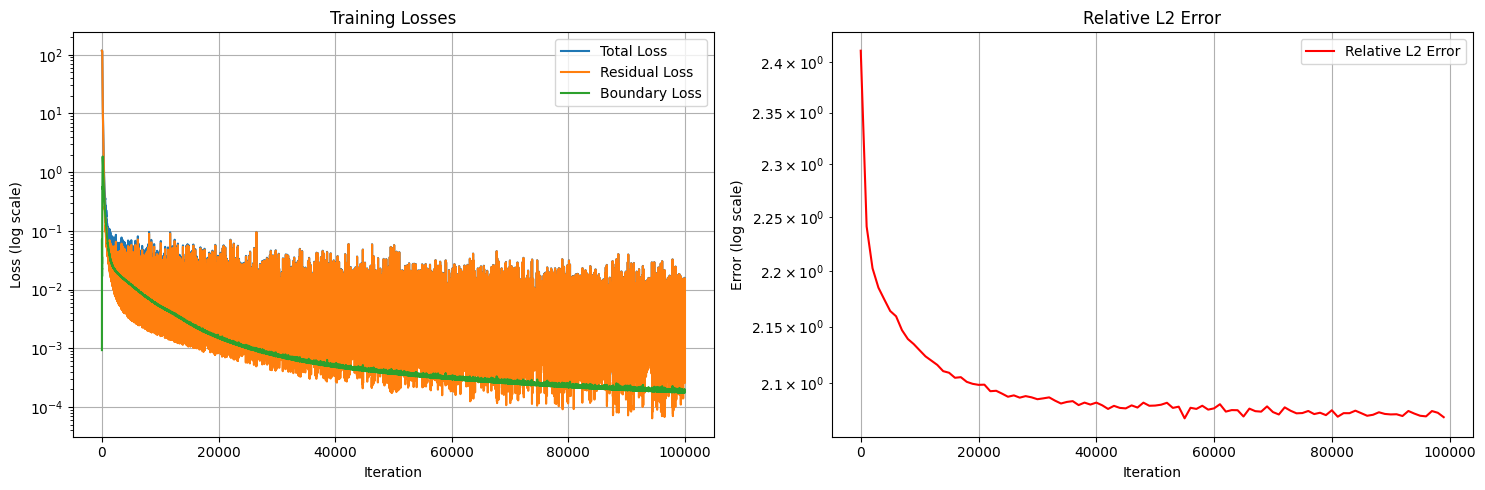

Loss: 1.74e-03 (R: 1.55e-03, B: 1.86e-04), Error: 2.07e+00: 100%|██████████| 100000/100000 [45:37<00:00, 36.53it/s]



Training completed! Best error: 2.07e+00


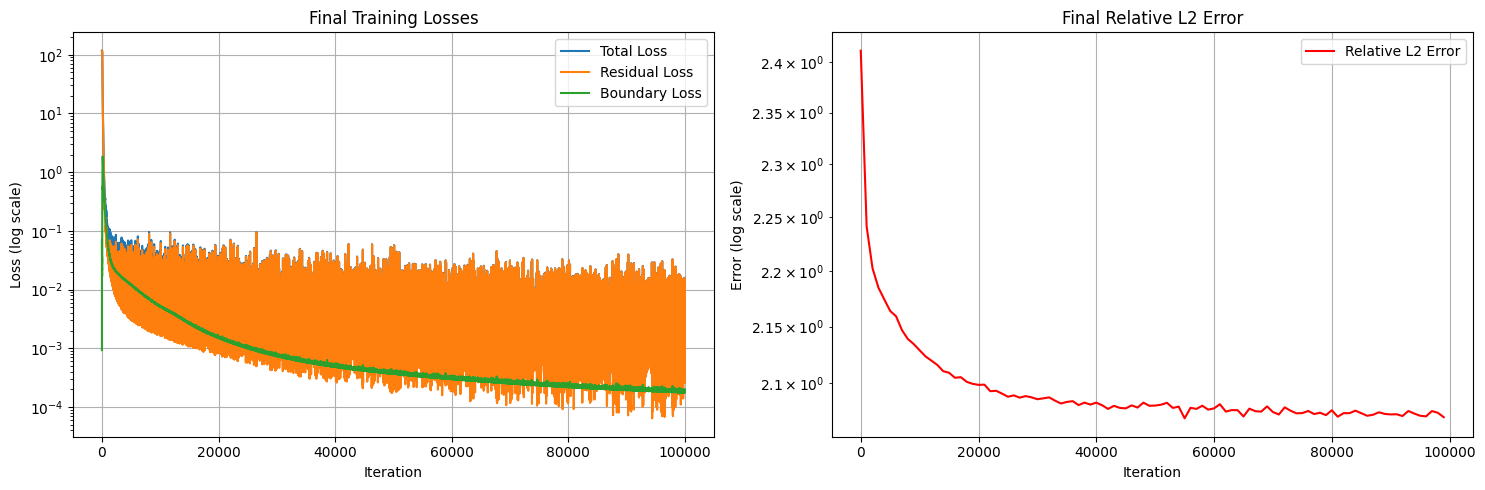

In [6]:
PARAMS = {
    'NC': 1000,        # количество точек коллокации
    'NB': 100,         # количество граничных точек
    'NC_TEST': 50,     # количество тестовых точек
    'SEED': 42,        # seed для воспроизводимости
    'LR': 1e-3,        # скорость обучения
    'EPOCHS': 100000,   # количество эпох
    'N_LAYERS': 3,     # количество слоев
    'FEATURES': 99,    # размер признаков
    'LOG_ITER': 1000,  # частота логирования
    'LAMBDA': 1.0      # параметр уравнения Гельмгольца (k)
}

error_history = main(**PARAMS)

In [8]:
error_history

[2.4112420082092285,
 2.241407632827759,
 2.2028450965881348,
 2.185180425643921,
 2.1744778156280518,
 2.1640892028808594,
 2.1593172550201416,
 2.146925687789917,
 2.1390388011932373,
 2.1345114707946777]